# Dual-Loss Ensemble + RL Analysis

This notebook runs the full experiment in two sections:
1. **MSE objective**
2. **LINEX objective**

It includes:
- tuned regular online ensembling methods,
- best individual forecaster comparison,
- HHI concentration diagnostics,
- three RL variants in the same summary tables:
  - Rule selection bandit
  - Kappa selection bandit
  - Simplex bandit

Timing alignment is strictly horizon-safe via:
- `y_target = pi[h:]`
- `F = forecasts_h[:-h]`
- `s = s_unc[:-h]`


In [1]:
import sys
from pathlib import Path
import importlib
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

PROJECT_ROOT = Path.cwd().resolve().parent if Path.cwd().name == 'analyses' else Path.cwd().resolve()
ANALYSES_DIR = PROJECT_ROOT / 'analyses'
OUT_DIR = ANALYSES_DIR / 'results'
OUT_DIR.mkdir(parents=True, exist_ok=True)

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
if str(ANALYSES_DIR) not in sys.path:
    sys.path.insert(0, str(ANALYSES_DIR))

import run_dual_loss_with_rl as runner
runner = importlib.reload(runner)

print('Project root:', PROJECT_ROOT)
print('Output dir:', OUT_DIR)
print('Runner:', runner.__file__)


Project root: /home/clayt/Ensemble-Forecasting
Output dir: /home/clayt/Ensemble-Forecasting/analyses/results
Runner: /home/clayt/Ensemble-Forecasting/analyses/run_dual_loss_with_rl.py


## Configuration


In [2]:
SCENARIO = 'discriminating'
HORIZONS = [1, 4, 8]
T = 1400
WINDOW = 150

TUNING_SEEDS = [0, 1, 2, 3]
TEST_SEEDS = [4, 5, 6, 7, 8, 9]
N_TRIALS = 35

LINEX_A = 1.0
SIMPLEX_REG_KAPPA = 0.3
KAPPA_GRID = np.array([0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 8.0], dtype=float)

LOSS_SECTIONS = [('mse', 'squared', 'mse'), ('linex', 'linex', 'linex')]
METHODS = list(runner.ot.DEFAULT_METHOD_PARAMS.keys())

print('Methods:', METHODS)


Methods: ['Mean', 'Median', 'OGDVanilla', 'MWUMVanilla', 'OGDBoth', 'OGDConcOnly', 'MWUMBothKL', 'MWUMConcOnlyKL']


## Tune Regular Methods By Horizon (Both Loss Sections)


In [3]:
tuning_rows = []
tuned_by_loss_h = {}

for loss_section, ens_loss, objective_metric in LOSS_SECTIONS:
    tuned_by_h = {}
    print(f'\n=== Tuning section: {loss_section.upper()} ===')
    for h in HORIZONS:
        slices_h = []
        for seed in TUNING_SEEDS:
            data_t, forecasts_t, _, s_unc_t = runner.simulator.make_environment_and_forecasts(
                T=T, horizons=HORIZONS, window=WINDOW, seed=seed, include_oracle=False, scenario=SCENARIO
            )
            y_t, F_t, s_t = runner.align_for_horizon(data_t['pi'], forecasts_t[h], s_unc_t, h)
            slices_h.append((y_t, F_t, s_t))

        tuned_h = runner.ot.tune_all_methods_optuna(
            data_slices=slices_h,
            methods=METHODS,
            n_trials=N_TRIALS,
            seed=42 + 100 * h,
            loss=ens_loss,
            linex_a=LINEX_A,
            objective_metric=objective_metric,
        )

        tuned_by_h[h] = {m: dict(tuned_h[m].best_params) for m in METHODS}
        for m in METHODS:
            tuning_rows.append({
                'loss_section': loss_section,
                'horizon': float(h),
                'method': m,
                'best_params': str(tuned_h[m].best_params),
                'tuning_objective': float(tuned_h[m].best_value),
            })

    tuned_by_loss_h[loss_section] = tuned_by_h

tuning_df = pd.DataFrame(tuning_rows).sort_values(['loss_section', 'horizon', 'tuning_objective']).reset_index(drop=True)
display(tuning_df)



=== Tuning section: MSE ===


[I 2026-02-16 15:16:00,052] A new study created in memory with name: no-name-fc8bfb0c-5201-4626-bc8a-e7abbf6579c1
[I 2026-02-16 15:16:00,056] A new study created in memory with name: no-name-98847332-06b3-4665-a4a9-a49dc4125e81
[I 2026-02-16 15:16:00,058] A new study created in memory with name: no-name-f34656a9-f6bb-4059-bae5-a170dc01a80f
[I 2026-02-16 15:16:00,140] Trial 0 finished with value: 0.9750400010255719 and parameters: {'eta': 0.008116076157212304}. Best is trial 0 with value: 0.9750400010255719.
[I 2026-02-16 15:16:00,209] Trial 1 finished with value: 0.9527323640132535 and parameters: {'eta': 0.00347441289862208}. Best is trial 1 with value: 0.9527323640132535.
[I 2026-02-16 15:16:00,285] Trial 2 finished with value: 0.9709836686883979 and parameters: {'eta': 0.007124784397429192}. Best is trial 1 with value: 0.9527323640132535.
[I 2026-02-16 15:16:00,358] Trial 3 finished with value: 1.1729561371405237 and parameters: {'eta': 0.10030664921071857}. Best is trial 1 with val


=== Tuning section: LINEX ===


[I 2026-02-16 15:16:56,926] A new study created in memory with name: no-name-b8794979-ffe8-4456-87fa-5dd245e1846e
[I 2026-02-16 15:16:56,929] A new study created in memory with name: no-name-d1168e6c-3210-43d4-a3fd-9e7766814f63
[I 2026-02-16 15:16:56,930] A new study created in memory with name: no-name-c013ebe2-b3b8-431d-a8b9-69d5d7b50717
[I 2026-02-16 15:16:57,015] Trial 0 finished with value: 2.4204162574635504 and parameters: {'eta': 0.008116076157212304}. Best is trial 0 with value: 2.4204162574635504.
[I 2026-02-16 15:16:57,096] Trial 1 finished with value: 2.2939481641653865 and parameters: {'eta': 0.00347441289862208}. Best is trial 1 with value: 2.2939481641653865.
[I 2026-02-16 15:16:57,180] Trial 2 finished with value: 2.3773246382880275 and parameters: {'eta': 0.007124784397429192}. Best is trial 1 with value: 2.2939481641653865.
[I 2026-02-16 15:16:57,261] Trial 3 finished with value: 3.0832774450336795 and parameters: {'eta': 0.10030664921071857}. Best is trial 1 with val

,loss_section,horizon,method,best_params,tuning_objective
0,linex,1.0,Mean,{},1.571689
1,linex,1.0,MWUMConcOnlyKL,{'kappa': 7.849943290518327},1.873713
2,linex,1.0,MWUMBothKL,"{'eta': 0.05059635030485148, 'kappa': 7.982919...",1.886837
3,linex,1.0,MWUMVanilla,{'eta': 0.001071380345127959},1.967996
4,linex,1.0,Median,{},2.139773
5,linex,1.0,OGDVanilla,{'eta': 0.0031709028216475085},2.291313
6,linex,1.0,OGDBoth,"{'eta': 0.00302272642675273, 'kappa': 0.003670...",2.291583
7,linex,1.0,OGDConcOnly,{'kappa': 7.989067040220606},2.579141
8,linex,4.0,OGDBoth,"{'eta': 0.031220593023844168, 'kappa': 3.62438...",5.365783
9,linex,4.0,MWUMConcOnlyKL,{'kappa': 1.8557563808482023},5.381440


## Evaluate On Test Seeds (Regular + RL Methods)


In [5]:
all_rows = []
all_diag_rows = []

for loss_section, _, _ in LOSS_SECTIONS:
    print(f'\n=== Evaluating section: {loss_section.upper()} ===')
    for seed in TEST_SEEDS:
        rows, diag_rows = runner.evaluate_one_seed(
            seed=seed,
            horizons=HORIZONS,
            T=T,
            window=WINDOW,
            scenario=SCENARIO,
            loss_section=loss_section,
            linex_a=LINEX_A,
            params_map_by_h=tuned_by_loss_h[loss_section],
            kappa_grid=KAPPA_GRID,
            simplex_reg_kappa=SIMPLEX_REG_KAPPA,
        )
        all_rows.extend(rows)
        all_diag_rows.extend(diag_rows)

summary_rows = runner.aggregate(all_rows)

detailed_df = pd.DataFrame(all_rows).sort_values(['loss_section', 'horizon', 'seed', 'method']).reset_index(drop=True)
summary_df = pd.DataFrame(summary_rows).sort_values(['loss_section', 'horizon', 'objective_mean']).reset_index(drop=True)
diag_df = pd.DataFrame(all_diag_rows).sort_values(['loss_section', 'horizon', 'seed', 'method', 't']).reset_index(drop=True)

print('Detailed rows:', len(detailed_df))
print('Summary rows:', len(summary_df))
print('Diagnostics rows:', len(diag_df))
display(summary_df)



=== Evaluating section: MSE ===

=== Evaluating section: LINEX ===
Detailed rows: 396
Summary rows: 66
Diagnostics rows: 110160


,loss_section,horizon,method,objective_mean,objective_std,mse_mean,mae_mean,linex_mean,avg_hhi_mean,avg_lambda_mean,avg_excess_objective_vs_best_individual,diag_main_mean,diag_aux_mean
0,linex,1.0,RLKappaBandit,0.240999,0.094719,0.378242,0.364157,0.240999,0.231034,0.685476,-0.393590,0.776118,0.380882
1,linex,1.0,Mean,0.721882,0.154857,0.844159,0.632936,0.721882,0.055556,NaN,0.087293,NaN,NaN
2,linex,1.0,MWUMVanilla,0.723602,0.143041,0.832474,0.624188,0.723602,0.057969,NaN,0.089013,NaN,NaN
3,linex,1.0,MWUMBothKL,0.728609,0.152008,0.846952,0.629717,0.728609,0.056542,7.885528,0.094020,NaN,NaN
4,linex,1.0,MWUMConcOnlyKL,0.732733,0.154039,0.849968,0.630316,0.732733,0.057397,7.754173,0.098145,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,mse,8.0,RLRuleBandit,3.669369,1.148176,3.669369,1.350112,83.838684,0.220359,NaN,-0.162757,2.500000,0.637582
62,mse,8.0,MWUMVanilla,3.889110,0.855192,3.889110,1.397579,14.928525,0.976766,NaN,0.056984,NaN,NaN
63,mse,8.0,Median,4.203720,1.056330,4.203720,1.457396,19.090638,NaN,NaN,0.371594,NaN,NaN
64,mse,8.0,Mean,4.431510,1.142928,4.431510,1.525453,22.275095,0.055556,NaN,0.599384,NaN,NaN


## Save Outputs


In [6]:
detailed_csv = OUT_DIR / 'dual_loss_full_detailed.csv'
summary_csv = OUT_DIR / 'dual_loss_full_summary.csv'
tuning_csv = OUT_DIR / 'dual_loss_full_tuned_params.csv'
diag_csv = OUT_DIR / 'dual_loss_full_policy_diagnostics.csv'
report_md = OUT_DIR / 'dual_loss_full_report.md'

runner.write_csv(detailed_csv, detailed_df.to_dict(orient='records'))
runner.write_csv(summary_csv, summary_df.to_dict(orient='records'))
runner.write_csv(tuning_csv, tuning_df.to_dict(orient='records'))
runner.write_csv(diag_csv, diag_df.to_dict(orient='records'))
runner.write_report(report_md, summary_df.to_dict(orient='records'), tuning_df.to_dict(orient='records'), linex_a=LINEX_A)

print('Wrote:', detailed_csv)
print('Wrote:', summary_csv)
print('Wrote:', tuning_csv)
print('Wrote:', diag_csv)
print('Wrote:', report_md)


Wrote: /home/clayt/Ensemble-Forecasting/analyses/results/dual_loss_full_detailed.csv
Wrote: /home/clayt/Ensemble-Forecasting/analyses/results/dual_loss_full_summary.csv
Wrote: /home/clayt/Ensemble-Forecasting/analyses/results/dual_loss_full_tuned_params.csv
Wrote: /home/clayt/Ensemble-Forecasting/analyses/results/dual_loss_full_policy_diagnostics.csv
Wrote: /home/clayt/Ensemble-Forecasting/analyses/results/dual_loss_full_report.md


## Plot: Objective Comparison By Horizon


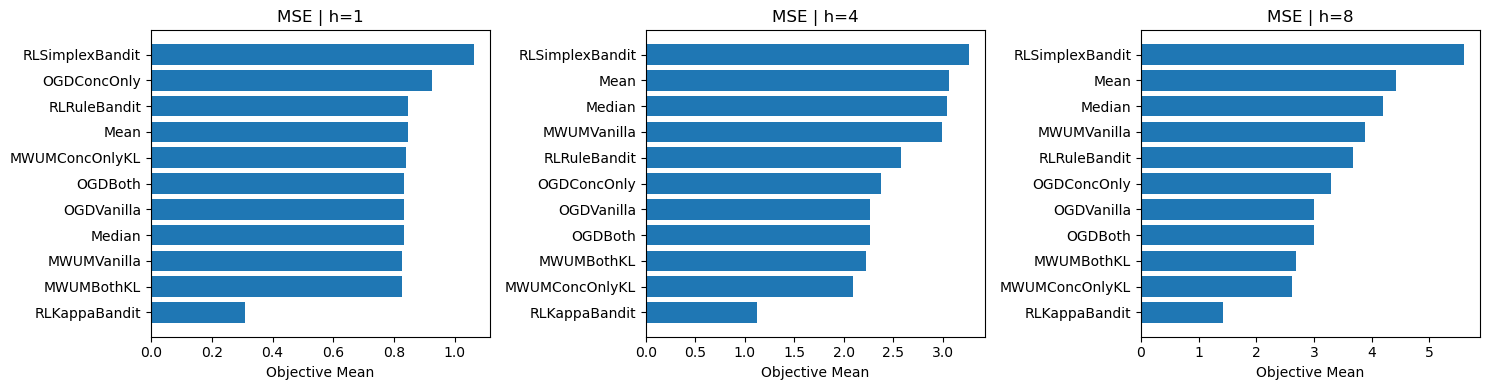

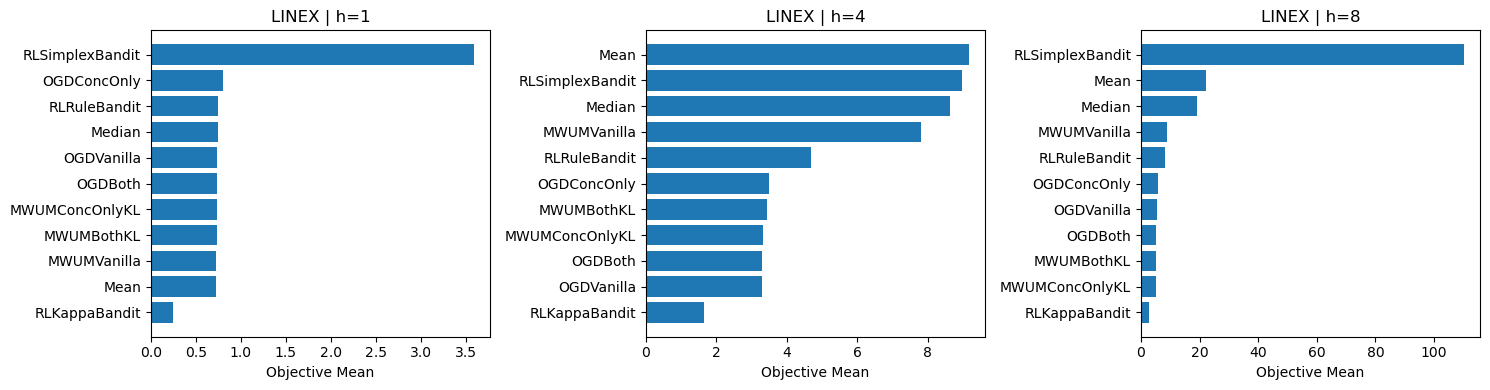

In [7]:
for loss_section in ['mse', 'linex']:
    fig, axes = plt.subplots(1, len(HORIZONS), figsize=(5 * len(HORIZONS), 4), sharey=False)
    if len(HORIZONS) == 1:
        axes = [axes]
    for ax, h in zip(axes, HORIZONS):
        sub = summary_df[(summary_df['loss_section'] == loss_section) & (summary_df['horizon'] == float(h))].copy()
        sub = sub.sort_values('objective_mean')
        ax.barh(sub['method'], sub['objective_mean'])
        ax.set_title(f'{loss_section.upper()} | h={h}')
        ax.set_xlabel('Objective Mean')
    plt.tight_layout()
    plt.show()


## Plot: Concentration (Average HHI)


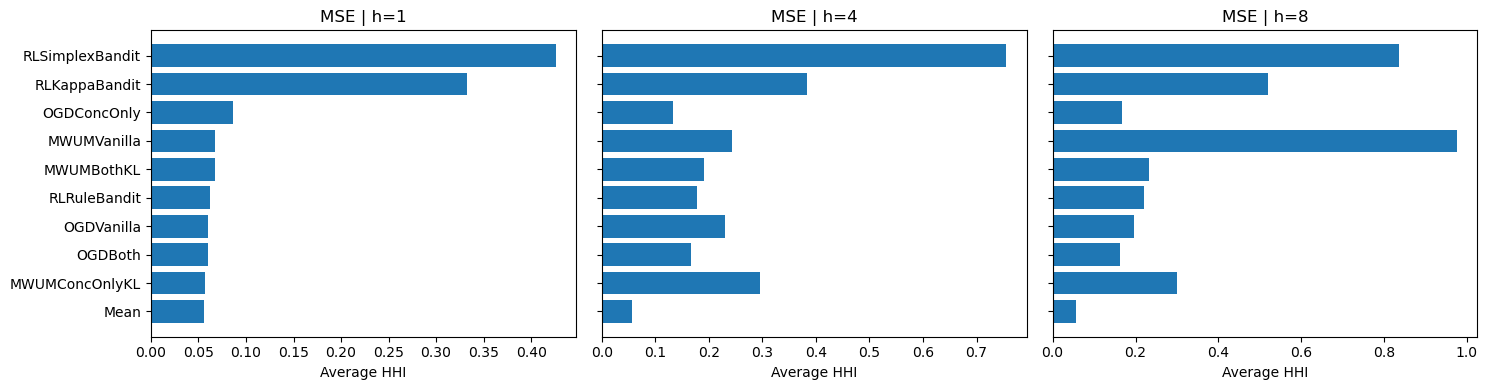

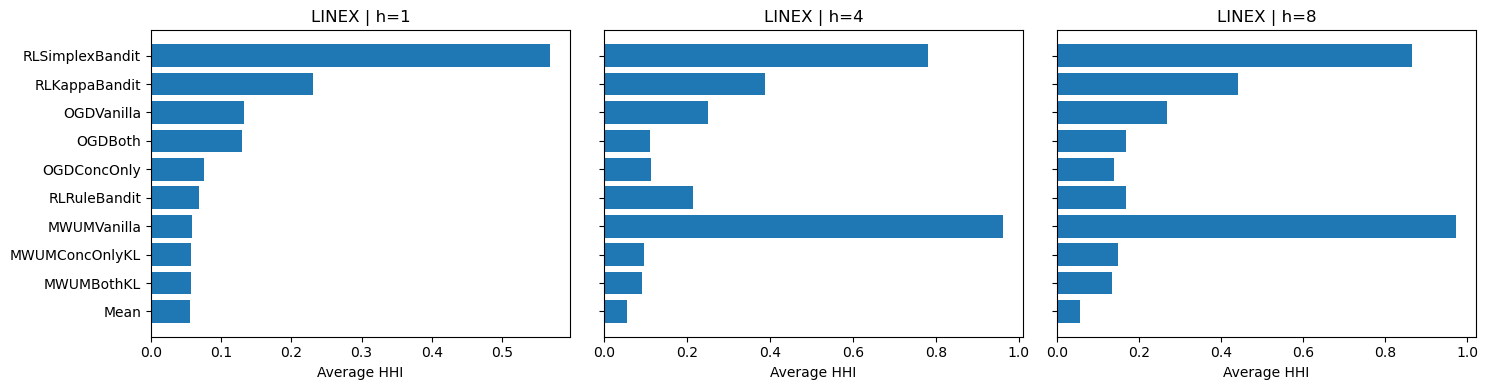

In [8]:
for loss_section in ['mse', 'linex']:
    fig, axes = plt.subplots(1, len(HORIZONS), figsize=(5 * len(HORIZONS), 4), sharey=True)
    if len(HORIZONS) == 1:
        axes = [axes]
    for ax, h in zip(axes, HORIZONS):
        sub = summary_df[(summary_df['loss_section'] == loss_section) & (summary_df['horizon'] == float(h))].copy()
        sub = sub.sort_values('avg_hhi_mean', na_position='last')
        ax.barh(sub['method'], sub['avg_hhi_mean'])
        ax.set_title(f'{loss_section.upper()} | h={h}')
        ax.set_xlabel('Average HHI')
    plt.tight_layout()
    plt.show()


## RL Diagnostics: Rule Selection Shares


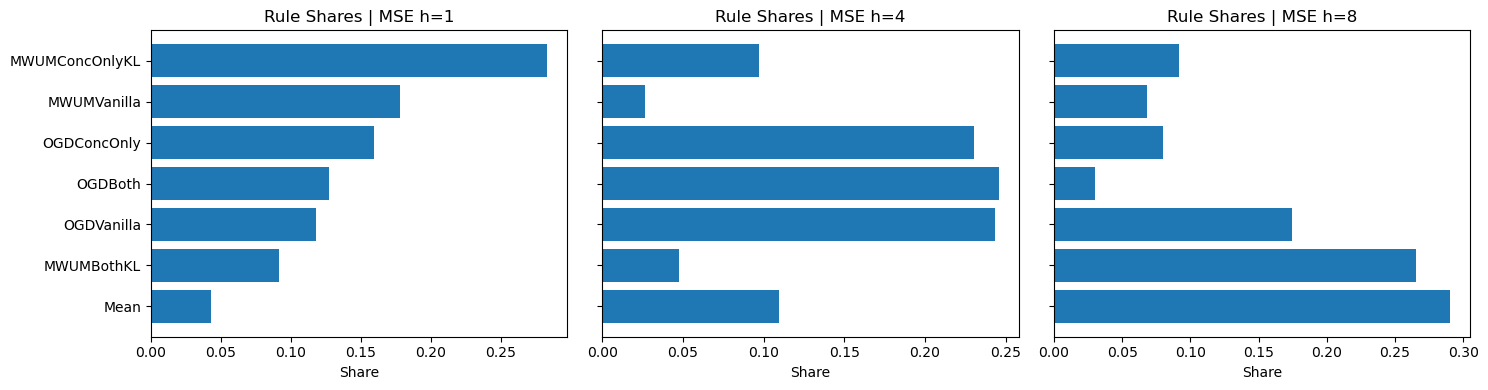

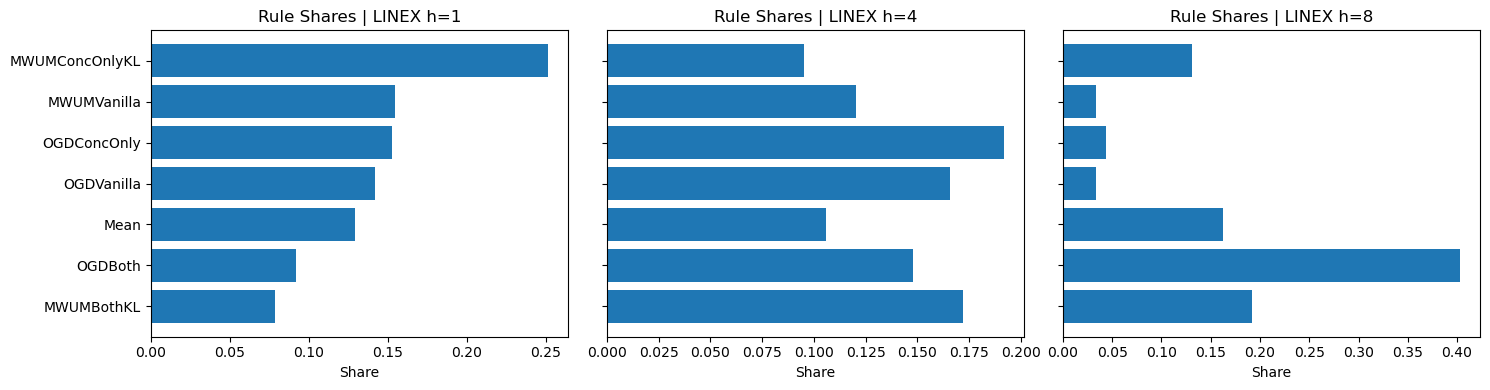

In [9]:
rule_diag = diag_df[diag_df['method'] == 'RLRuleBandit'].copy()
if not rule_diag.empty:
    shares = (
        rule_diag.groupby(['loss_section', 'horizon', 'action_name'])
        .size()
        .reset_index(name='count')
    )
    shares['share'] = shares.groupby(['loss_section', 'horizon'])['count'].transform(lambda x: x / x.sum())

    for loss_section in ['mse', 'linex']:
        fig, axes = plt.subplots(1, len(HORIZONS), figsize=(5 * len(HORIZONS), 4), sharey=True)
        if len(HORIZONS) == 1:
            axes = [axes]
        for ax, h in zip(axes, HORIZONS):
            sub = shares[(shares['loss_section'] == loss_section) & (shares['horizon'] == float(h))].sort_values('share')
            ax.barh(sub['action_name'], sub['share'])
            ax.set_title(f'Rule Shares | {loss_section.upper()} h={h}')
            ax.set_xlabel('Share')
        plt.tight_layout()
        plt.show()
else:
    print('No rule-bandit diagnostics available.')


## RL Diagnostics: Kappa Trajectory (Example Seed/Horizon)


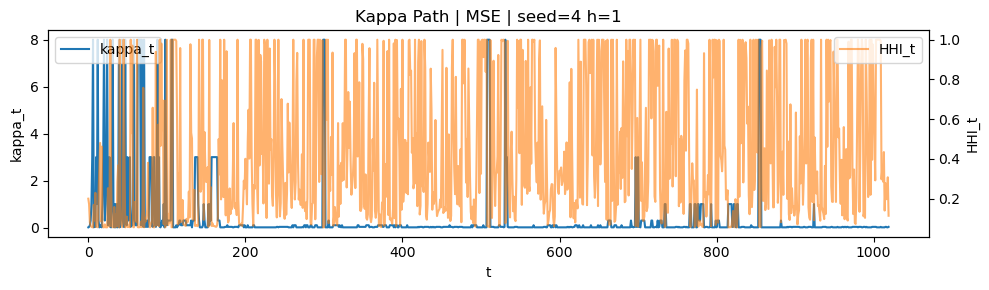

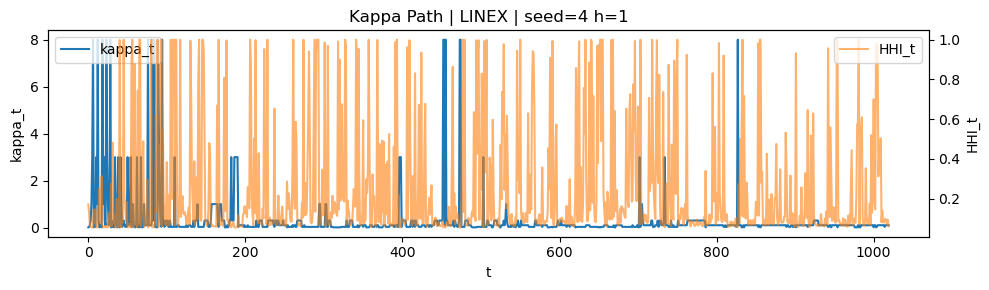

In [10]:
kdiag = diag_df[diag_df['method'] == 'RLKappaBandit'].copy()
if not kdiag.empty:
    for loss_section in ['mse', 'linex']:
        seed0 = float(TEST_SEEDS[0])
        h0 = float(HORIZONS[0])
        sub = kdiag[(kdiag['loss_section'] == loss_section) & (kdiag['seed'] == seed0) & (kdiag['horizon'] == h0)]

        fig, ax1 = plt.subplots(figsize=(10, 3))
        ax1.plot(sub['t'], sub['kappa'], label='kappa_t')
        ax1.set_title(f'Kappa Path | {loss_section.upper()} | seed={int(seed0)} h={int(h0)}')
        ax1.set_xlabel('t')
        ax1.set_ylabel('kappa_t')
        ax1.legend(loc='upper left')

        ax2 = ax1.twinx()
        ax2.plot(sub['t'], sub['hhi_t'], color='tab:orange', alpha=0.6, label='HHI_t')
        ax2.set_ylabel('HHI_t')
        ax2.legend(loc='upper right')
        plt.tight_layout()
        plt.show()
else:
    print('No kappa-bandit diagnostics available.')


## RL Diagnostics: Simplex Conservatism (HHI + KL, Example Seed/Horizon)


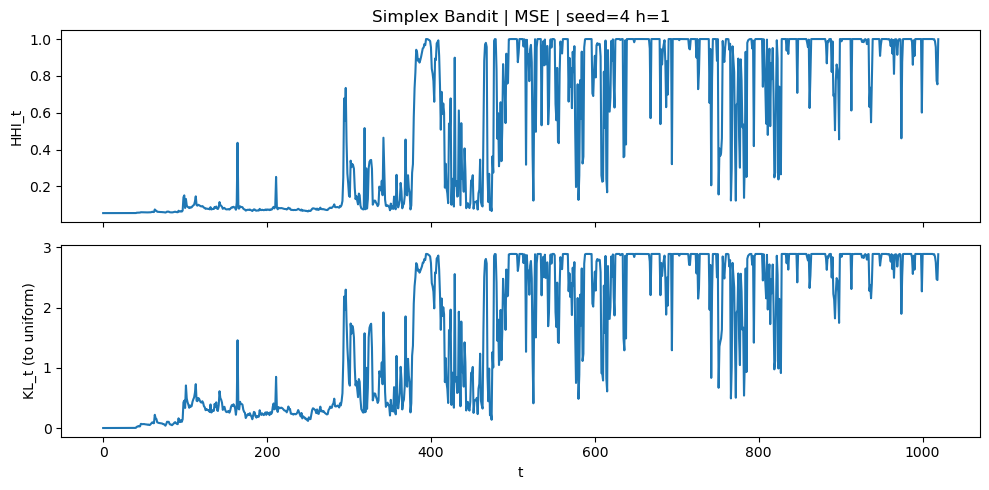

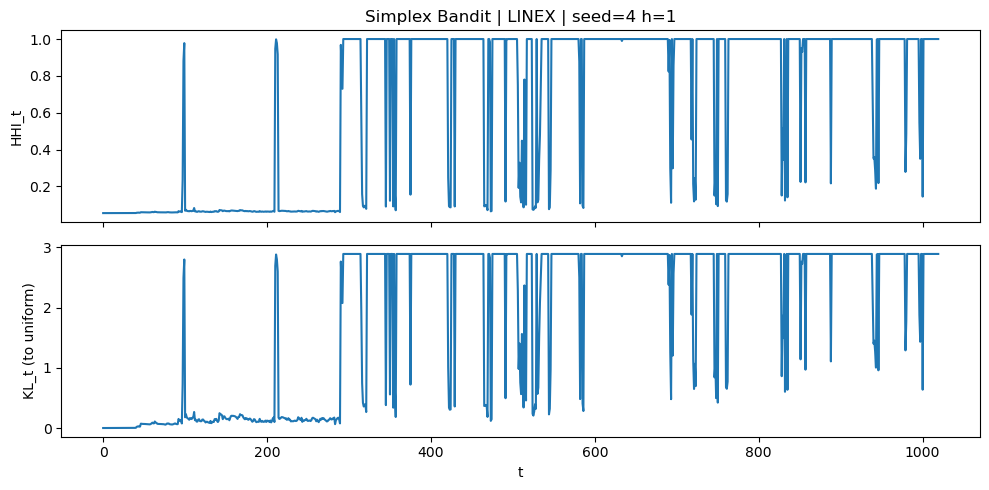

In [11]:
sdiag = diag_df[diag_df['method'] == 'RLSimplexBandit'].copy()
if not sdiag.empty:
    for loss_section in ['mse', 'linex']:
        seed0 = float(TEST_SEEDS[0])
        h0 = float(HORIZONS[0])
        sub = sdiag[(sdiag['loss_section'] == loss_section) & (sdiag['seed'] == seed0) & (sdiag['horizon'] == h0)].copy()

        fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
        axes[0].plot(sub['t'], sub['hhi_t'])
        axes[0].set_title(f'Simplex Bandit | {loss_section.upper()} | seed={int(seed0)} h={int(h0)}')
        axes[0].set_ylabel('HHI_t')

        if 'kl_t' in sub.columns:
            axes[1].plot(sub['t'], sub['kl_t'])
            axes[1].set_ylabel('KL_t (to uniform)')
        axes[1].set_xlabel('t')
        plt.tight_layout()
        plt.show()
else:
    print('No simplex-bandit diagnostics available.')
